Loading fpe_training_data.npy...
Total Steps: 51
Split: Washout=5, Train=25, Test=21

--- Training (Classical ESN) ---
R2 Score: 1.00000
--- Testing (Classical ESN) ---
Prediction Shape: (20, 200)


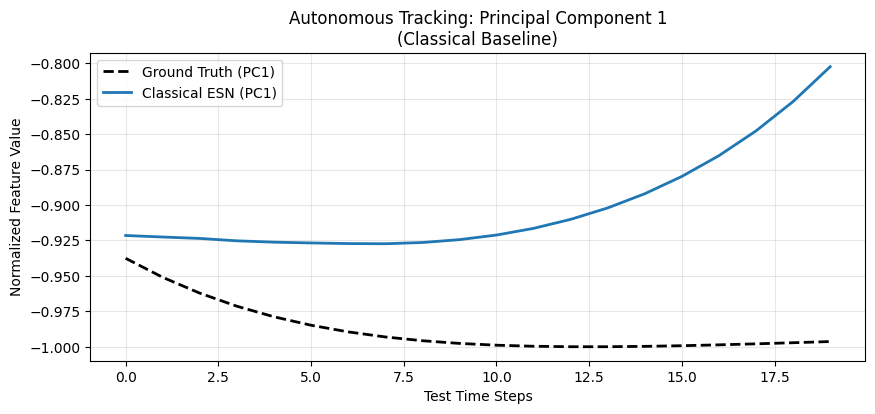

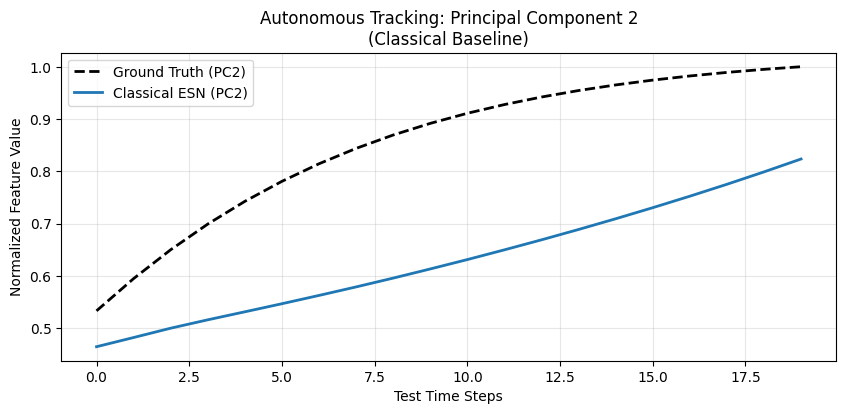

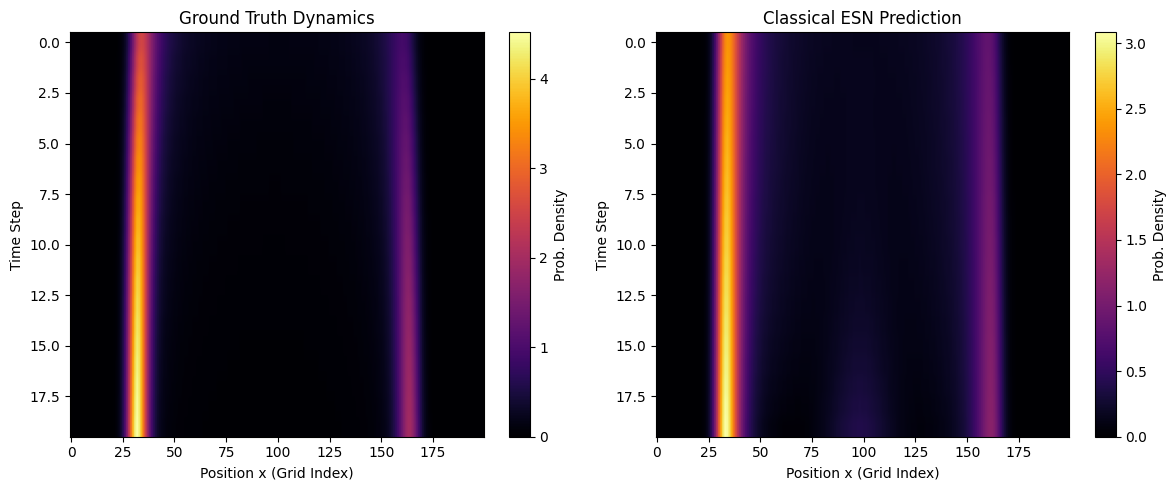

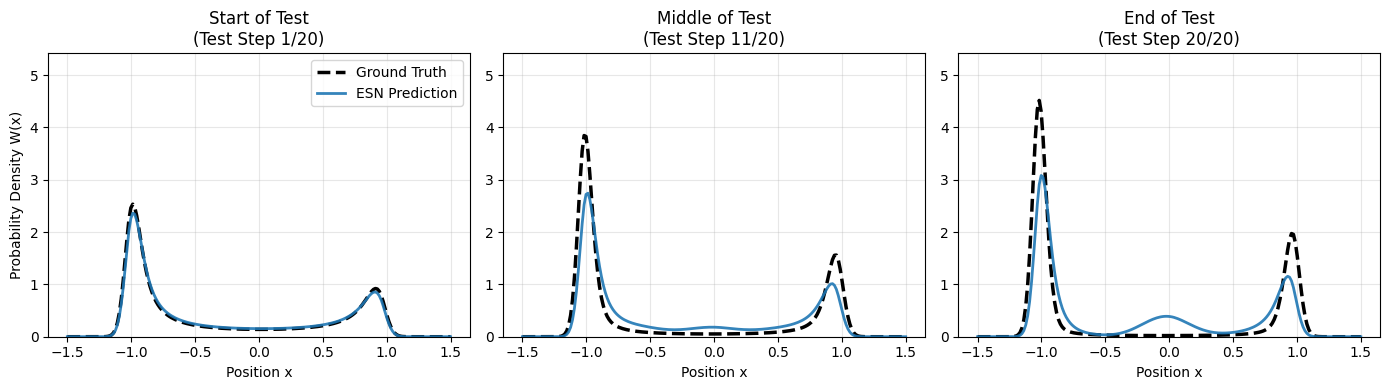


 CLASSICAL BASELINE REPORT
MSE (Raw Error):       7.096218e-02
NMSE (Normalized):     0.1493
Avg Fidelity:          0.9275
------------------------------


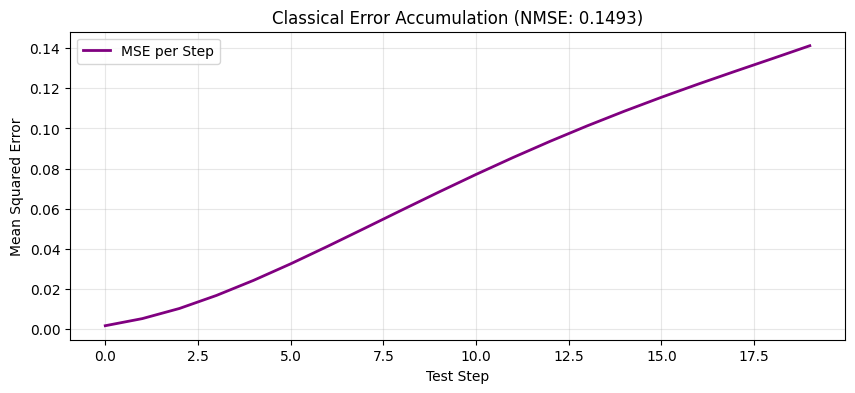

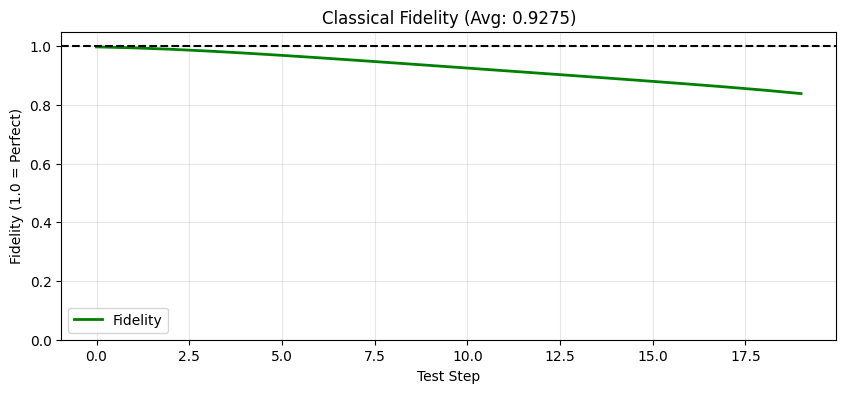

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# --- 1. CONFIGURATION (Matched to QRC) ---
filename = 'fpe_training_data.npy'
washout_len = 5
train_len = 25    
n_inputs = 4      
alpha_reg = 0.001 

# Classical Reservoir Specifics
n_reservoir = 100      # Classical hidden size (approx equivalent to Hilbert space dim)
spectral_radius = 0.95 # Stability parameter
sparsity = 0.1         # Connectivity density

# --- 2. DATA PREPARATION ---
print(f"Loading {filename}...")
data_full = np.load(filename)
n_time_steps = data_full.shape[0]
test_len = n_time_steps - washout_len - train_len

print(f"Total Steps: {n_time_steps}")
print(f"Split: Washout={washout_len}, Train={train_len}, Test={test_len}")

# PCA Compression
pca = PCA(n_components=n_inputs)
pca.fit(data_full[:washout_len+train_len])
data_pca = pca.transform(data_full)

# Scaling (Standard for Tanh is -1 to 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data_pca)

# Training Sets
X_train_pca = data_scaled[washout_len : washout_len + train_len]      
Y_train_full = data_full[washout_len + 1 : washout_len + train_len + 1] 

# Testing Sets (Ground Truth)
Y_test_full_gt = data_full[washout_len + train_len + 1 :] 

# --- 3. CLASSICAL RESERVOIR SETUP ---
np.random.seed(42)

# Input -> Reservoir
W_in = np.random.uniform(-1, 1, (n_reservoir, n_inputs))

# Reservoir -> Reservoir (Recurrent)
W_res = np.random.uniform(-1, 1, (n_reservoir, n_reservoir))
# Enforce sparsity
mask = np.random.rand(n_reservoir, n_reservoir) > sparsity
W_res[mask] = 0
# Scale spectral radius for Echo State Property
rho_W = np.max(np.abs(np.linalg.eigvals(W_res)))
W_res *= (spectral_radius / rho_W)

def update_reservoir(x_old, u_new):
    # Standard ESN equation: x(t) = tanh( Win*u(t) + Wres*x(t-1) )
    return np.tanh(np.dot(W_in, u_new) + np.dot(W_res, x_old))

# --- 4. TRAINING LOOP ---
print("\n--- Training (Classical ESN) ---")
x_state = np.zeros(n_reservoir)
X_res_states = []

# Washout
for t in range(washout_len):
    x_state = update_reservoir(x_state, data_scaled[t+1])

# Train
for t in range(train_len):
    x_state = update_reservoir(x_state, data_scaled[washout_len + t + 1])
    X_res_states.append(x_state.copy())

X_res_states = np.array(X_res_states)

# Train Readout
ridge = Ridge(alpha=alpha_reg)
ridge.fit(X_res_states, Y_train_full)
print(f"R2 Score: {ridge.score(X_res_states, Y_train_full):.5f}")

# --- 5. AUTONOMOUS TESTING ---
print("--- Testing (Classical ESN) ---")

predictions = []
curr_x_state = x_state # Start from state at end of training
steps_to_predict = len(Y_test_full_gt)

# Start the loop
curr_pred_vec = ridge.predict(curr_x_state.reshape(1, -1)).flatten()
curr_pred_vec[curr_pred_vec < 0] = 0

for t in range(steps_to_predict):
    # Store prediction
    predictions.append(curr_pred_vec)
    
    # Feedback (Autonomous)
    pred_pca = scaler.transform(pca.transform(curr_pred_vec.reshape(1,-1))).flatten()
    curr_x_state = update_reservoir(curr_x_state, pred_pca)
    
    # Predict next
    curr_pred_vec = ridge.predict(curr_x_state.reshape(1, -1)).flatten()
    curr_pred_vec[curr_pred_vec < 0] = 0

predictions = np.array(predictions)
print(f"Prediction Shape: {predictions.shape}")

# --- 7. VISUALIZATION ---

# 1. Project predictions and ground truth back into the PCA Latent Space
pred_pca_history = scaler.transform(pca.transform(predictions))
gt_pca_history = scaler.transform(pca.transform(Y_test_full_gt))
time_steps = np.arange(len(predictions))

# --- Plot A: Principal Component 1 ---
plt.figure(figsize=(10, 4))
plt.plot(time_steps, gt_pca_history[:, 0], label="Ground Truth (PC1)", color='black', linestyle='--', linewidth=2)
plt.plot(time_steps, pred_pca_history[:, 0], label="Classical ESN (PC1)", color='#1f77b4', linewidth=2) # Blue
plt.title(f"Autonomous Tracking: Principal Component 1\n(Classical Baseline)")
plt.xlabel("Test Time Steps")
plt.ylabel("Normalized Feature Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot B: Principal Component 2 ---
plt.figure(figsize=(10, 4))
plt.plot(time_steps, gt_pca_history[:, 1], label="Ground Truth (PC2)", color='black', linestyle='--', linewidth=2)
plt.plot(time_steps, pred_pca_history[:, 1], label="Classical ESN (PC2)", color='#1f77b4', linewidth=2) # Blue
plt.title(f"Autonomous Tracking: Principal Component 2\n(Classical Baseline)")
plt.xlabel("Test Time Steps")
plt.ylabel("Normalized Feature Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Plot C: Full System Evolution Heatmap ---
plt.figure(figsize=(12, 5))

# Ground Truth
plt.subplot(1, 2, 1)
plt.imshow(Y_test_full_gt, aspect='auto', cmap='inferno', origin='upper')
plt.title(f"Ground Truth Dynamics")
plt.xlabel("Position x (Grid Index)")
plt.ylabel("Time Step")
plt.colorbar(label="Prob. Density")

# Classical Prediction
plt.subplot(1, 2, 2)
plt.imshow(predictions, aspect='auto', cmap='inferno', origin='upper')
plt.title(f"Classical ESN Prediction")
plt.xlabel("Position x (Grid Index)")
plt.ylabel("Time Step")
plt.colorbar(label="Prob. Density")

plt.tight_layout()
plt.show()

# --- Plot D: W(x, t) Cross-Sections (Slices) ---
x_vals = np.linspace(-1.5, 1.5, 200)
test_indices = [0, len(predictions) // 2, len(predictions) - 1]
time_labels = ["Start of Test", "Middle of Test", "End of Test"]

plt.figure(figsize=(14, 4))

for i, idx in enumerate(test_indices):
    plt.subplot(1, 3, i+1)
    
    # Ground Truth
    plt.plot(x_vals, Y_test_full_gt[idx], color='black', linestyle='--', 
             linewidth=2.5, label='Ground Truth')
    
    # Classical Prediction
    plt.plot(x_vals, predictions[idx], color='#1f77b4', linestyle='-', 
             linewidth=2, alpha=0.9, label='ESN Prediction')
    
    plt.title(f"{time_labels[i]}\n(Test Step {idx+1}/{len(predictions)})")
    plt.xlabel("Position x")
    
    if i == 0:
        plt.ylabel("Probability Density W(x)")
        plt.legend(loc='upper right')
        
    plt.grid(True, alpha=0.3)
    plt.ylim(0, np.max(Y_test_full_gt) * 1.2)

plt.tight_layout()
plt.show()

# --- 8. QUANTITATIVE METRICS ---
# 1. Calculate Global Metrics
mse = mean_squared_error(Y_test_full_gt, predictions)
variance_target = np.var(Y_test_full_gt)
nmse = mse / variance_target

# 2. Calculate Fidelity
fidelity_over_time = []
for t in range(len(predictions)):
    p_safe = np.maximum(predictions[t], 1e-10)
    q_safe = np.maximum(Y_test_full_gt[t], 1e-10)
    f = np.sum(np.sqrt(p_safe * q_safe)) ** 2
    norm_factor = np.sum(p_safe) * np.sum(q_safe)
    fidelity_over_time.append(f / norm_factor)

avg_fidelity = np.mean(fidelity_over_time)

# 3. Print Report
print("\n" + "="*30)
print(f" CLASSICAL BASELINE REPORT")
print("="*30)
print(f"MSE (Raw Error):       {mse:.6e}")
print(f"NMSE (Normalized):     {nmse:.4f}")
print(f"Avg Fidelity:          {avg_fidelity:.4f}")
print("-" * 30)

# 4. Plot Error Drift
mse_over_time = np.mean((predictions - Y_test_full_gt)**2, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(mse_over_time, color='purple', linewidth=2, label='MSE per Step')
plt.title(f"Classical Error Accumulation (NMSE: {nmse:.4f})")
plt.xlabel("Test Step")
plt.ylabel("Mean Squared Error")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 5. Plot Fidelity Drift
plt.figure(figsize=(10, 4))
plt.plot(fidelity_over_time, color='green', linewidth=2, label='Fidelity')
plt.axhline(1.0, color='black', linestyle='--')
plt.title(f"Classical Fidelity (Avg: {avg_fidelity:.4f})")
plt.xlabel("Test Step")
plt.ylabel("Fidelity (1.0 = Perfect)")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()